In [22]:
import numpy as np
from scipy.sparse import csr_matrix as sparse_mat
import pickle
import sys
from sklearn.cross_validation import train_test_split
import math

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# settings for plots
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
# returns the non-zero entries from the sparse matrix
def non_zero(sparse_matrix):
    return np.transpose(sparse_matrix.nonzero())

## Loading Ratings Matrix Pickle

In [3]:
ratings = pickle.load(open('pickles/ratings_matrix.p', 'rb'))

In [4]:
ratings.shape

(552339, 77445)

---
## Splitting the Dataset into Training, Validation and Testing Sets
##### Do Not Run This Everytime

- Training Set: 70%  
- Test Set: 30%  

In [31]:
training = []
testing = []
sample = []

for j, business in enumerate(ratings.T):
    indices = non_zero(business)
    indices = [[idx[1], j] for idx in indices]
    if len(indices) > 10:
        train, test = train_test_split(indices, test_size=0.3, random_state=42)
        training.extend(train)
        testing.extend(test)
        if np.random.uniform(low=0, high=1) <= 0.1:
            sample.extend(train)
    else:
        training.extend(indices)
        if np.random.uniform(low=0, high=1) <= 0.1:
            sample.extend(indices)

#### Saving split data into pickles, so that we can evaluate all models on the same training, validation and testing sets

In [32]:
training_sample, validation_sample = train_test_split(sample, test_size=0.3, random_state=42)

In [35]:
pickle.dump(training, open('pickles/training_indices.p', 'wb'))
pickle.dump(testing, open('pickles/testing_indices.p', 'wb'))

In [40]:
pickle.dump(training_sample, open('pickles/training_samples.p', 'wb'))
pickle.dump(validation_sample, open('pickles/validation_samples.p', 'wb'))

---

### Load training, validation and testing data directly

In [4]:
training = pickle.load(open('pickles/training_indices.p', 'rb'))
testing = pickle.load(open('pickles/testing_indices.p', 'rb'))

##### Load the training and validation sample directly if required

In [6]:
training_sample = pickle.load(open('pickles/training_samples.p', 'rb'))
validation_sample = pickle.load(open('pickles/validation_samples.p', 'rb'))

## The Latent Factor Model, without considering reviews:

#### Batch Gradient Descent Approach:
Clearly, this is very slow, but it gives proper results.

In [10]:
def train_latent_factors(R, training_indices, k=2, eta=1e-2, lamb=1e-2, threshold=1e-4, iterations=1000, stochastic=False):
    m, n = R.shape
    U = np.random.uniform(-1, 1, (m, k))
    B = np.random.uniform(-1, 1, (n, k))
    i = 0
    prev = 0
    curr = sys.maxint
    T = len(training_indices)
    while i < iterations and abs(curr - prev) > threshold:
        prev = curr
        cost = 0
        for idx in training_indices:
            epsilon = R[idx[0], idx[1]] - np.dot(U[idx[0]], B[idx[1]].T)
            temp_U = U[idx[0], :] + eta * (epsilon * B[idx[1]] - lamb * U[idx[0], :])
            B[idx[1], :] = B[idx[1], :] + eta * (epsilon * U[idx[0]] - lamb * B[idx[1], :])
            U[idx[0], :] = temp_U
            cost += (R[idx[0], idx[1]] - np.dot(U[idx[0]], B[idx[1]].T )) ** 2 + \
                                    lamb * (np.linalg.norm(U[idx[0]])**2 + np.linalg.norm(B[idx[1]])**2)

        cost = math.sqrt(cost / T)
        if stochastic == True:
            print "Stochastic Training RMSE: ", cost
            break
        
        # 
        curr = cost
        print "RMSE:", curr
        i += 1
        
    # print "Total Iterations: ", i
    return U, B

#### Run for user, business and review loading directly

In [6]:
user_map = pickle.load(open('pickles/users_map.p', 'rb'))
business_map = pickle.load(open('pickles/business_map.p', 'rb'))
reviews = pickle.load(open('pickles/reviews.p', 'rb'))

#### Global and Individual Baselines have to be adjusted before training

In [5]:
baselines = pickle.load(open('pickles/baselines.p', 'rb'))
alpha = baselines['alpha']
beta_users = baselines['beta_users']
beta_business = baselines['beta_business']

In [6]:
# removing baselines from ratings data
for idx in non_zero(ratings):
    ratings[idx[0], idx[1]] -= (alpha + beta_users[idx[0]] + beta_business[idx[1]])

##### Train the model on the training set

In [19]:
U, B = train_latent_factors(ratings, training, k=10, iterations=50)

0.000850987737661
0.000715884893602
0.000621437228679
0.000551492144223
0.000497422119349
0.000454202038018
0.000418706776023
0.000388890672492
0.0003633590322
0.000341129454906
0.000321491573338
0.000303920778515
0.00028802302697
0.000273498307584
0.000260115728536
0.000247696077583
0.000236099327363
0.0002252154965
0.000214957840416
0.000205257693694
0.000196060506569
0.000187322761477
0.000179009550455
0.000171092657916
0.000163549036647
0.000156359594491
0.000149508229676
0.000142981066994
0.000136765857163
0.00013085150906
0.000125227730074
0.000119884754202
0.00011481314104
0.000110003631786
0.000105447050826
0.000101134243525
9.7056042538e-05
9.32032562931e-05
8.95666743826e-05
8.61370854656e-05
8.29053039624e-05
7.98622024088e-05
7.69987468342e-05
7.43060329834e-05
7.17753216215e-05
6.93980715571e-05
6.71659693821e-05
6.50709552622e-05
6.31052444006e-05
6.12613440465e-05
Total Iterations:  50


In [20]:
reviews.head(5)

,business_id,review_id,stars,text,user_id
0,5UmKMjUEUNdYWqANhGckJw,Ya85v4eqdd6k9Od8HbQjyA,4,"Mr Hoagie is an institution. Walking in, it do...",PUFPaY9KxDAcGqfsorJp3Q
1,5UmKMjUEUNdYWqANhGckJw,KPvLNJ21_4wbYNctrOwWdQ,5,Excellent food. Superb customer service. I mis...,Iu6AxdBYGR4A0wspR9BYHA
2,5UmKMjUEUNdYWqANhGckJw,fFSoGV46Yxuwbr3fHNuZig,5,Yes this place is a little out dated and not o...,auESFwWvW42h6alXgFxAXQ
3,UsFtqoBl7naz8AVUBZMjQQ,Di3exaUCFNw1V4kSNW5pgA,5,All the food is great here. But the best thing...,uK8tzraOp4M5u3uYrqIBXg
4,UsFtqoBl7naz8AVUBZMjQQ,0Lua2-PbqEQMjD9r89-asw,3,We checked this place out this past Monday for...,I_47G-R2_egp7ME5u_ltew


### Validate the model on a random sample of 10000 points:

- Sample the first 10% businesses from the total data.
- Split the sample into training and validation only (70 - 30)
- Train for range of $\lambda$, and compute errors on validation.
- The $\lambda$ with best error is saved and used for training the full dataset

The full data will be split into 70-30 train test

In [7]:
def predict(u_idx, b_idx, U, B):
    return np.dot(U[u_idx], B[b_idx].T) + alpha + beta_users[u_idx] + beta_business[b_idx]

In [8]:
def errors(test_set, U, B, ratings=ratings):
    error = 0
    for idx in test_set:
        u_idx = idx[0]
        b_idx = idx[1]
        error += (ratings[u_idx, b_idx] - predict(u_idx, b_idx, U, B)) ** 2
    return math.sqrt(error/len(test_set))

In [10]:
def validate(training_sample, validation_sample, ratings=ratings, start=0.005, end=0.02, steps=0.001):
    best_error = sys.maxint
    best_lambda = 0
    for lam in np.arange(start, end, steps):
        U, B = train_latent_factors(ratings, training_sample, k=10, iterations=50, lamb=lam)
        error = errors(validation_sample, U, B)
        if (error < best_error):
            best_error = error
            best_lambda = lam
    return best_lambda

In [33]:
best_lambda = validate(training_sample, validation_sample)

0.000929771713575
0.000809912206745
0.000708718656482
0.000622561279765
0.000548716003906
0.000485083173571
0.000430009823869
0.000382172020538
0.000340494044881
0.000304091203343
0.000272228339811
0.000244289101153
0.000219752754325
0.000198176421919
0.000179181278232
0.000162441686856
0.000147676553501
0.000134642367447
0.000123127544255
0.000112947781296
0.000103942209204
9.59701748288e-05
8.8908530197e-05
8.26493310739e-05
7.70978705598e-05
7.21709896033e-05
6.77956187136e-05
6.39075145106e-05
6.04501618533e-05
5.73738176816e-05
5.46346768657e-05
5.21941435786e-05
5.001819426e-05
4.80768202802e-05
4.63435400849e-05
4.47949719826e-05
4.34104599071e-05
4.21717454769e-05
4.10626805314e-05
4.00689750611e-05
3.91779760927e-05
3.83784736534e-05
3.76605304242e-05
3.70153321242e-05
3.64350560408e-05
3.59127554467e-05
3.54422579315e-05
3.50180759259e-05
3.46353279122e-05
3.42896690067e-05
Total Iterations:  50
0.000919286305693
0.000805145717077
0.000708137899161
0.000625072141376
0.0005535

In [9]:
best_lambda = 0.016

### Run the Latent Factors model for k = [1,2,5,8,10]

In [11]:
# train the model with final set of parameters
test_errors_latent_factors = []
min_err = sys.maxint
best_U = None
best_B = None
best_k = None
best_error = None
ks = [1,2,5,8,10]
for k in ks:
    U, B = train_latent_factors(ratings, training, lamb=best_lambda, stochastic=True)
    error = errors(testing, U, B)
    if error < min_err:
        best_k = k
        best_U = U
        best_B = B
        best_error = error
    test_errors_latent_factors.append(error)
    print "k:", k, "error:", error

Stochastic Training RMSE:  1.1483872049
k:  1 error:  4.1421316837
Stochastic Training RMSE:  1.14850545601
k:  2 error:  4.14253522423
Stochastic Training RMSE:  1.14829345132
k:  5 error:  4.14263406057
Stochastic Training RMSE:  1.14902041367
k:  8 error:  4.14245560707
Stochastic Training RMSE:  1.14817183143
k:  10 error:  4.1422755649


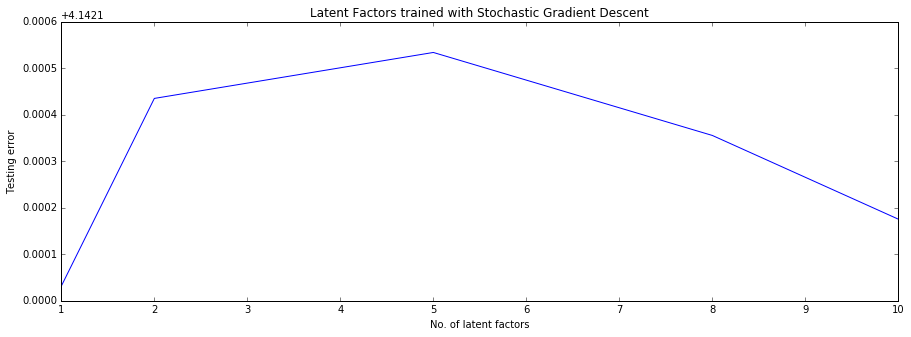

In [23]:
plt.plot(np.asarray(ks), np.asarray(test_errors_latent_factors))
plt.xlabel("No. of latent factors")
plt.ylabel("Testing error")
plt.title("Latent Factors trained with Stochastic Gradient Descent")

In [12]:
k = 1
U, B = train_latent_factors(ratings, training, k=k, lamb=best_lambda)
error = errors(testing, U, B)
if error < min_err:
    best_k = k
    best_U = U
    best_B = B
test_errors_latent_factors.append(error)
print "k : ", k, "error : ", error

RMSE: 1.11888959581
RMSE: 1.1029422083
RMSE: 1.09564278196
RMSE: 1.09080909854
RMSE: 1.08714006022
RMSE: 1.08413066863
RMSE: 1.08153300192
RMSE: 1.07920751299
RMSE: 1.07706819187
RMSE: 1.07505850502
RMSE: 1.07313950889
RMSE: 1.07128344041
RMSE: 1.06947001587
RMSE: 1.06768417053
RMSE: 1.06591461065
RMSE: 1.0641528462
RMSE: 1.06239251957
RMSE: 1.06062892358
RMSE: 1.05885864436
RMSE: 1.05707928962
RMSE: 1.05528927717
RMSE: 1.05348766734
RMSE: 1.05167402861
RMSE: 1.04984832895
RMSE: 1.04801084765
RMSE: 1.04616210382
RMSE: 1.04430279857
RMSE: 1.04243376843
RMSE: 1.04055594819
RMSE: 1.03867034131
RMSE: 1.0367779966
RMSE: 1.03487998997
RMSE: 1.0329774101
RMSE: 1.03107134727
RMSE: 1.0291628847
RMSE: 1.02725309169
RMSE: 1.02534301835
RMSE: 1.02343369148
RMSE: 1.02152611141
RMSE: 1.01962124974
RMSE: 1.01772004767
RMSE: 1.01582341507
RMSE: 1.01393222991
RMSE: 1.01204733819
RMSE: 1.01016955409
RMSE: 1.00829966027
RMSE: 1.00643840829
RMSE: 1.00458651895
RMSE: 1.00274468248
RMSE: 1.00091355865
RMSE:

In [ ]:
k = 2
U, B = train_latent_factors(ratings, training, k=k, lamb=best_lambda)
error = errors(testing, U, B)
if error < min_err:
    best_k = k
    best_U = U
    best_B = B
test_errors_latent_factors.append(error)
print "k : ", k, "error : ", error

In [ ]:
k = 5
U, B = train_latent_factors(ratings, training, k=k, lamb=best_lambda)
error = errors(testing, U, B)
if error < min_err:
    best_k = k
    best_U = U
    best_B = B
test_errors_latent_factors.append(error)
print "k : ", k, "error : ", error

In [ ]:
k = 8
U, B = train_latent_factors(ratings, training, k=k, lamb=best_lambda)
error = errors(testing, U, B)
if error < min_err:
    best_k = k
    best_U = U
    best_B = B
test_errors_latent_factors.append(error)
print "k : ", k, "error : ", error

In [ ]:
k = 10
U, B = train_latent_factors(ratings, training, k=k, lamb=best_lambda)
error = errors(testing, U, B)
if error < min_err:
    best_k = k
    best_U = U
    best_B = B
test_errors_latent_factors.append(error)
print "k : ", k, "error : ", error

In [21]:
test_errors_latent_factors = errors(testing, U, B)
print "Mean Squared Error of Latent Factor Model: ", test_errors_latent_factors

Mean Squared Error of Latent Factor Model:  0.00550474466419


In [20]:
pickle.dump(U, open('latent_factor_U.p', 'wb'))
pickle.dump(B, open('latent_factor_B.p', 'wb'))